In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
from typing import Tuple, List, Dict


def get_simulation_files() -> Tuple[Dict[str, List[str]], Dict[str, List[str]], Dict[str, List[str]], Dict[str, List[str]]]:
    def add_file(dict : Dict, key: str, value: str) -> None:
        if key in dict:
            dict[key].append(value)
        else:
            dict[key] = [value]

    avg_degree, degree_distribution, giant_component, sizes_of_components = {}, {}, {}, {}
    for file in os.listdir():
        if file.endswith(".txt"):
            [filename, _] = file.split("(")
            if filename.endswith("avg_degree"):
                add_file(avg_degree, filename, file)
            elif filename.endswith("degree_distribution"):
                add_file(degree_distribution, filename, file)
            elif filename.endswith("giant_component"):
                add_file(giant_component, filename, file)
            elif filename.endswith("sizes_of_components"):
                add_file(sizes_of_components, filename, file)

    return avg_degree, degree_distribution, giant_component, sizes_of_components


def process_prefix(file_name: str) -> Tuple[int, int, float, float]:
    def get_fraction(fraction_str: str) -> float:
        [num, den] = fraction_str.split("d")
        return float(num) / float(den)

    file_info = file_name.split("_")
    num_nodes = int(file_info[1])
    steps = int(file_info[3])
    alpha = get_fraction(file_info[5])
    r = get_fraction(file_info[7])

    return num_nodes, steps, alpha, r


## Plot \<K\>(t)

In [3]:
from typing import Callable

import scipy.special as sc


def pk_builder(alpha, r) -> Callable[[float, float], float]:
    def c(t):
        return alpha / r * (1 - np.exp(-r * t))

    def Q(k, c):
        return sc.gammaincc(k, c)

    return lambda k, t: r / alpha * (1 - Q(k + 1, c(t))) + np.exp(-c(t) - r * t) * c(t) ** k / sc.factorial(k) 


def expected_k_builder(alpha, r) -> Callable[[float], float]:
    alphadr = alpha / r

    return lambda t: alphadr / 2 * (1 - np.exp(-2 * r * t))


In [4]:
def plot_avg_degree(prefix: str, file_list: List[str]) -> None:
    num_nodes, num_steps, alpha, r = process_prefix(prefix)
    print(num_nodes, num_steps, alpha, r)

    min_step: float = 1
    values = []
    for file in file_list:
        df = pd.read_csv(file)
        [min_step] = df.keys()
        values.append(df[min_step])
    print(min_step, float(min_step))
    min_step = float(min_step)

    grouped_files = pd.concat(values).groupby(level=0)
    mean, std = grouped_files.mean().values, grouped_files.std().values

    expected_k = expected_k_builder(alpha=alpha, r=r)

    x_values = np.arange(num_steps) * min_step / (float(num_nodes))
    plt.title("Nodes: " + str(num_nodes) + " Steps: " + str(num_steps))
    plt.errorbar(x_values, mean, yerr=std)
    plt.plot(x_values, list(map(expected_k, x_values)))
    plt.legend(
        [
            "Theory - alpha = " + str(alpha) + ", r = " + str(r),
            "Simul. - alpha = " + str(alpha) + ", r = " + str(r),
        ]
    )
    plt.show()


10000 50000 1.0 0.5
2  2.0


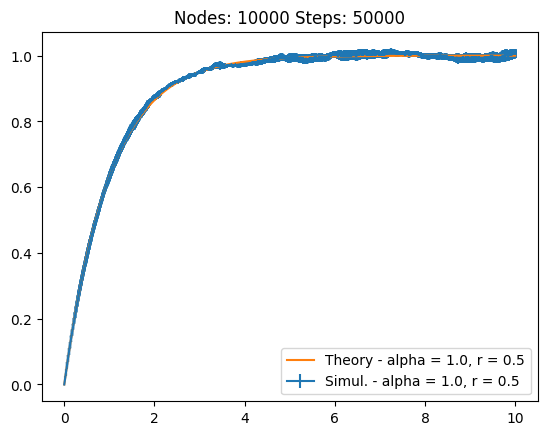

100 1000 2.0 0.5
1  1.0


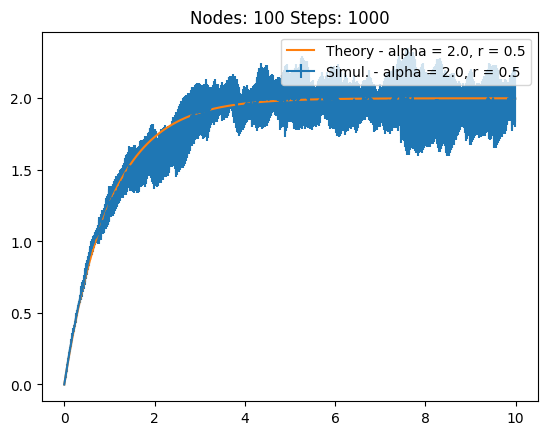

25000 50000 1.0 0.5
2  2.0


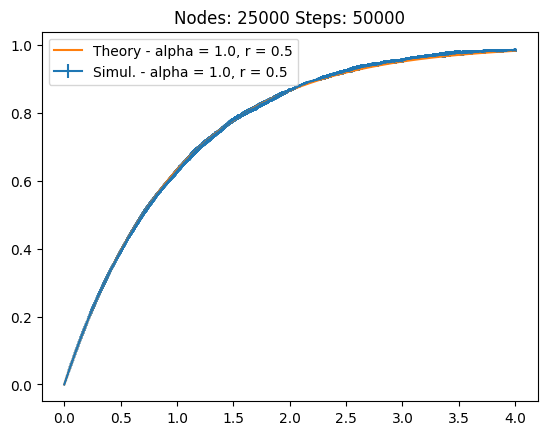

50000 50000 1.0 0.5
2  2.0


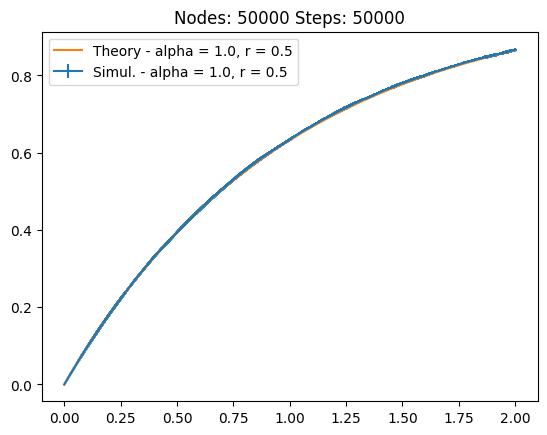

In [5]:
for prefix, file_list in get_simulation_files()[0].items():
    plot_avg_degree(prefix=prefix, file_list=file_list)


In [5]:
def calculate_mean(values: List[List[Dict[int, float]]]):

    num_files = len(values)
    num_steps = len(values[0])
    print(num_steps)

    def process(step_info: Dict[int, float], step: Dict[int, float]) -> None:
         for k, v in step_info.items():
            if not k in step:
                step[k] = float(v)/num_files
            else:
                 step[k] += float(v)/num_files

    series: List[Dict[int, float]] = []

    for i in range(0, num_steps):
            step = {}
            for file_data in values:
                process(file_data[i], step)
            series.append(step)
    
    series_as_dict = {}
    for idx, serie in enumerate(series):
        for key, value in serie.items():
            if not key in series_as_dict:
                series_as_dict[key] = np.zeros(num_steps)
            series_as_dict[key][idx] = value

    return series_as_dict

In [6]:
def plot_degree_distribution(prefix: str, file_list: List[str]) -> None:
    num_nodes, num_steps, alpha, r = process_prefix(prefix)
    print(num_nodes, num_steps, alpha, r)

    def build_dict(row):
        unique, counts = np.unique(row, return_counts=True)
        return dict(zip(unique, counts))

    values = []
    for file in file_list:
        df = pd.read_csv(file, skiprows=1, header=None, delimiter=" ")
        counts = list(map(lambda r: build_dict(r), df.values))
        values.append(counts)

    # I cannot do mean!! I first need to build dictionary, and then do mean over that!

    series = calculate_mean(values)

    min_step: float = 1

    with open(file_list[0]) as f:
        min_step = float(f.readline().strip("\n"))

    pk = pk_builder(alpha=alpha, r=r)

    x_values = np.arange(num_steps) * min_step / (float(num_nodes))

    for k, pk_values in series.items():
        if (k < 6):
            plt.yscale("log")
            plt.plot(x_values, pk_values / float(num_nodes), label=str(k) + " - simulation")
            plt.plot(x_values, list(map(lambda x: pk(k, x), x_values)), label=str(k) + " - theory")

    plt.legend()
    plt.title("Nodes: " + str(num_nodes) + " Steps: " + str(num_steps))
    plt.show()


10000 10000 1.0 0.5
10000


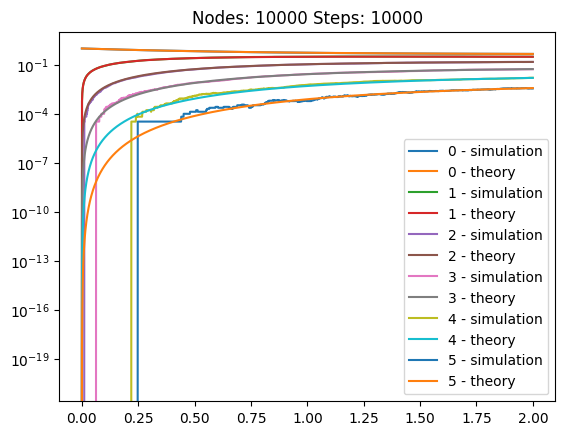

1000 5000 1.0 0.5
5000


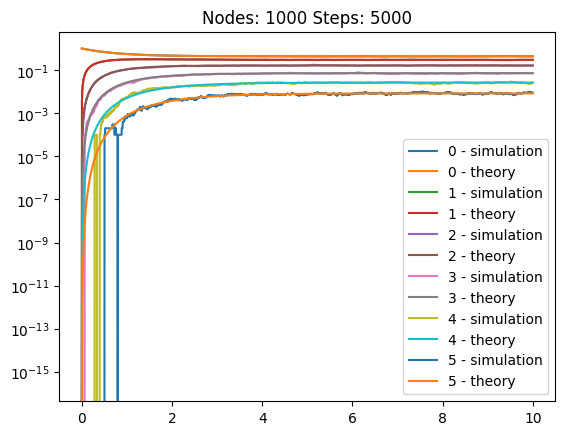

100 100000 2.0 2.5
60001


ValueError: x and y must have same first dimension, but have shapes (100000,) and (60001,)

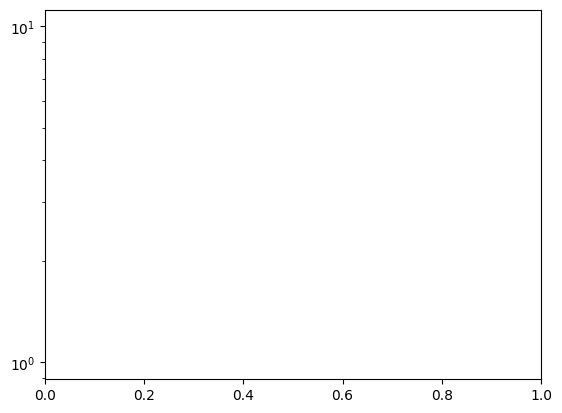

In [8]:
files = get_simulation_files()[1]
for prefix, file_list in files.items():
    plot_degree_distribution(prefix=prefix, file_list=file_list)


In [7]:
def giant_component_builder(
    alpha: float, r: float, num_nodes: int
) -> Callable[[float], float]:
    # We can restrict infinity to (num_nodes - 1) as pk k>= num_nodes - 1 = 0
    print(alpha, r, num_nodes)

    def s(t: float) -> float:
        expected_k = expected_k_builder(alpha=alpha, r=r)
        expected_k_t = expected_k(t)
        pk = pk_builder(alpha=alpha, r=r)
        pk_t = [pk(k, t) for k in range(0, num_nodes)]

        u_t = calculate_u(expected_k_t, pk_t)
        res = 0
        for k in range(1, num_nodes - 1):
            res += pk_t[k] * (1 - u_t**k)

        return res

    def calculate_u(expected_k_t: float, pk_t: List[float]) -> float:

        diff = 0.1  # It just needs to be better than the acceptance threshold
        u = 0.5  # Initial value
        while abs(diff) > 1e-3:
            sum_u = 0
            sum_du = 0
            for k in range(1, num_nodes):
                sum_u += k * pk_t[k] * (u ** (k - 1))
                sum_du += k * (k - 1) * pk_t[k] * (u ** (k - 2))
            diff = u - sum_u / expected_k_t
            u = u - (u - sum_u / expected_k_t)/(1 - sum_du / expected_k_t)
        return u

    return lambda t: 0 if t < 0.02 else s(t)


In [8]:
def plot_giant_component(prefix: str, file_list: List[str]) -> None:
    num_nodes, num_steps, alpha, r = process_prefix(prefix)
    print(num_nodes, num_steps, alpha, r)

    min_step: float = 1
    values = []
    for file in file_list:
        df = pd.read_csv(file)
        [min_step] = df.keys()
        values.append(df[min_step])
    min_step = float(min_step)

    grouped_files = pd.concat(values).groupby(level=0)
    mean, std = grouped_files.mean().values, grouped_files.std().values
    print("this done")

    # TODO:
    giant_component = giant_component_builder(alpha=alpha, r=r, num_nodes=num_nodes)

    x_values = np.arange(num_steps) * min_step / (float(num_nodes))
    x_theory_values = np.arange(num_steps/10) * 10 * min_step / (float(num_nodes))
    plt.title("Nodes: " + str(num_nodes) + " Steps: " + str(num_steps))
    plt.errorbar(x_values, mean/float(num_nodes), yerr=std/float(num_nodes))
    print("real_data_plotted")
    plt.plot(x_theory_values, list(map(giant_component, x_theory_values)))
    plt.show()


100 1000 1.0 0.5
this done
1.0 0.5 100
real_data_plotted


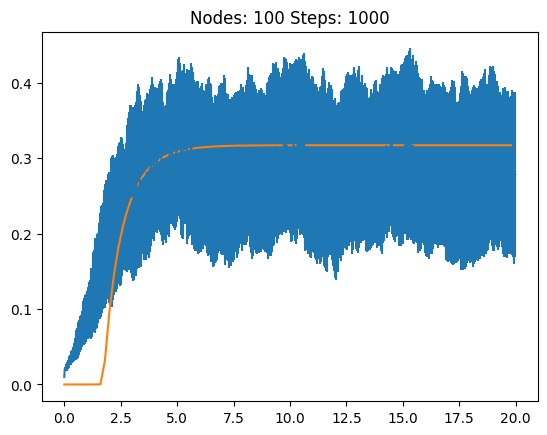

250 300 1.0 0.5
this done
1.0 0.5 250
real_data_plotted


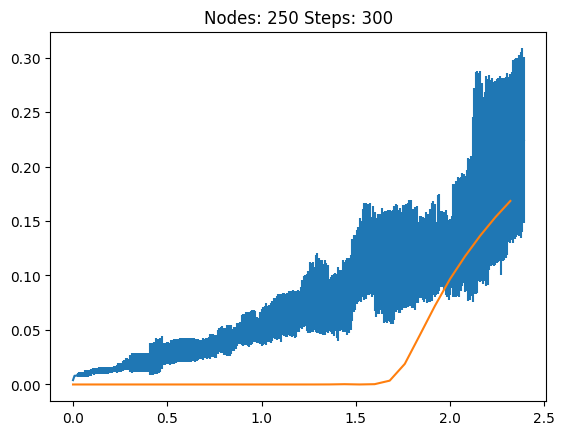

5000 10000 1.0 0.5
this done
1.0 0.5 5000
real_data_plotted


C:\Users\mique\AppData\Local\Temp\ipykernel_6644\2309462788.py:13: RuntimeWarning: overflow encountered in scalar power
  return lambda k, t: r / alpha * (1 - Q(k + 1, c(t))) + np.exp(-c(t) - r * t) * c(t) ** k / sc.factorial(k)
C:\Users\mique\AppData\Local\Temp\ipykernel_6644\2309462788.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return lambda k, t: r / alpha * (1 - Q(k + 1, c(t))) + np.exp(-c(t) - r * t) * c(t) ** k / sc.factorial(k)


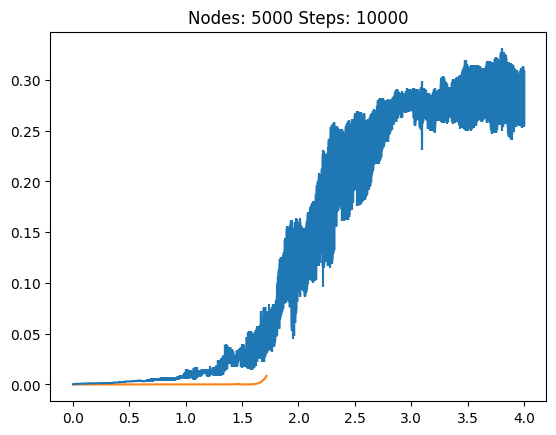

500 2000 1.0 0.5
this done
1.0 0.5 500
real_data_plotted


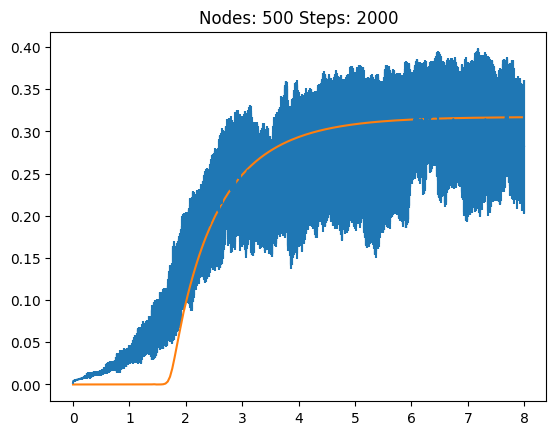

In [55]:
files = get_simulation_files()[2]
for prefix, file_list in files.items():
    plot_giant_component(prefix=prefix, file_list=file_list)


In [9]:
def first_passage_stats(column):
    max_degree_reached = 0
    step_when_degree_reached = np.zeros(1, dtype=np.int8)
    for step, degree in enumerate(column):
        if degree > max_degree_reached:
            step_when_degree_reached = np.append((step_when_degree_reached), step)
            max_degree_reached = degree
    return step_when_degree_reached


def p(distribution, first_passage, k, step):
    count = 0
    for node_idx in range(len(first_passage)):
        count += step < first_passage[node_idx][k + 1] and distribution[node_idx][step] == k
    return count
    


# Theory
def qk_t(k_star: int, t_values, alpha: float, r: float):
    def compute_step(qk, ak: float, AT: float):
        next_qk = np.zeros(k_star, dtype=np.float64)

        next_qk[0] = (
            qk[0] + (-(alpha + r) * qk[0] + r * qk[1] + r * qk[1] + r * (1 - ak)) * AT
        )

        for k in range(1, k_star - 1):
            next_qk[k] = (
                qk[k]
                + (
                    alpha * qk[k - 1]
                    - (alpha + r) * qk[k]
                    + r * (k + 1) * qk[k + 1]
                    - r * k * qk[k]
                )
                * AT
            )

        next_qk[k_star - 1] = (
            qk[k_star - 1]
            + (
                alpha * qk[k_star - 2]
                - (alpha + r) * qk[k_star - 1]
                - r * (k_star - 1) * qk[k_star - 1]
            )
            * AT
        )

        ak = ak + (alpha*qk[k_star - 1]) * AT

        return next_qk, ak

    qk = np.zeros(k_star, dtype=np.float64)
    qk[0] = 1
    ak: float = 0
    qk_t = []
    qk_t.append(qk)
    for i in range(0, len(t_values) - 1):
        qk, ak = compute_step(qk, ak, t_values[i + 1] - t_values[i])
        qk_t.append(qk)
    return np.array(qk_t)[:, -1]

def smooth_data(pk_plot):
    idx = pk_plot.size // 100
    while (np.count_nonzero(pk_plot[idx:idx+10] == 0) < 2):
        idx += 10
    pk_plot[idx:] = 0
    return pk_plot
    


In [10]:
def plot_first_passage_prob(file : str) -> None:
    num_nodes, num_steps, alpha, r = process_prefix(file)
    print(num_nodes, num_steps, alpha, r)

    df = pd.read_csv(file, skiprows=1, header=None, delimiter=" ")
    first_time = df.apply(first_passage_stats, axis=0)
    lowest_deg = 1000
    for serie in first_time:
        lowest_deg = min(lowest_deg, len(serie))
    print(lowest_deg)

    first_time = first_time.apply(lambda arr: np.resize(arr, lowest_deg + 1))
    
    min_step: float = 1

    with open(file) as f:
        min_step = float(f.readline().strip("\n"))
    
    k_values = list(range(3, lowest_deg - 2))
    
    t_values = list(range(0, num_steps, 10))
    pk_plots = []

    for k in k_values:
        pk_plots.append(np.asarray([p(df, first_time, k, t) for t in t_values]))
    
    pk_plots = list(map(smooth_data, pk_plots))

    plt.yscale("log")
    plt.xscale("log")

    for idx, pk_plot in enumerate(pk_plots):
        plt.plot(list(map(lambda t: t * min_step / float(num_nodes),t_values)), list(map(lambda x : x / float(num_nodes), pk_plot)), label = str(k_values[idx] + 1))

    t_values = np.linspace(0, 1e3, 10000) * min_step / float(num_nodes)
    for k in k_values:
        plt.plot(t_values, qk_t(k_star=k + 1, t_values=t_values,alpha=2,r=0.5), label = str(k + 1))    

    plt.legend()
    plt.title("Nodes: " + str(num_nodes) + " Steps: " + str(num_steps) + "alpha: " + str(alpha) + ", r: " + str(r))
    plt.show()


100 50000 2.0 0.5
9


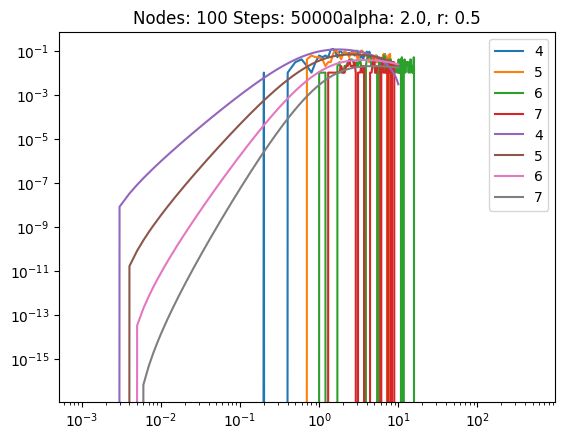

100 50000 2.0 0.2
13


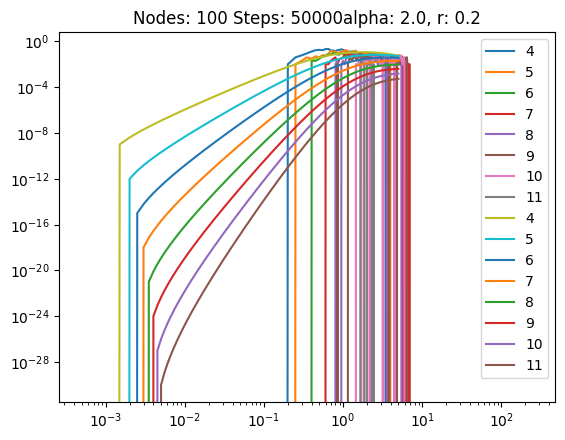

In [70]:
files = get_simulation_files()[1]
for prefix, file_list in files.items():
        num_nodes, num_steps, _, _ = process_prefix(prefix)
        if num_nodes == 100 and num_steps > 10000:
            for file in file_list:
                plot_first_passage_prob(file)

In [11]:
def plot_first_passage(file : str) -> None:
    num_nodes, num_steps, alpha, r = process_prefix(file)
    print(num_nodes, num_steps, alpha, r)

    df = pd.read_csv(file, skiprows=1, header=None, delimiter=" ")
    first_time = df.apply(first_passage_stats, axis=0)
    lowest_deg = 1000
    for serie in first_time:
        lowest_deg = min(lowest_deg, len(serie))
    print(lowest_deg)

    min_step: float = 1

    with open(file) as f:
        min_step = float(f.readline().strip("\n"))
    
    sized_first_time = first_time.apply(lambda arr: np.resize(arr, lowest_deg))
    avg_step = sized_first_time.sum() / 100
    times = avg_step * min_step / (float(num_nodes))

    plt.yscale("log")
    plt.plot(times, marker="o", linestyle="None")
    plt.title("Nodes: " + str(num_nodes) + " Steps: " + str(num_steps) + "alpha: " + str(alpha) + ", r: " + str(r))
    plt.show()


100 10000 2.0 2.5
3


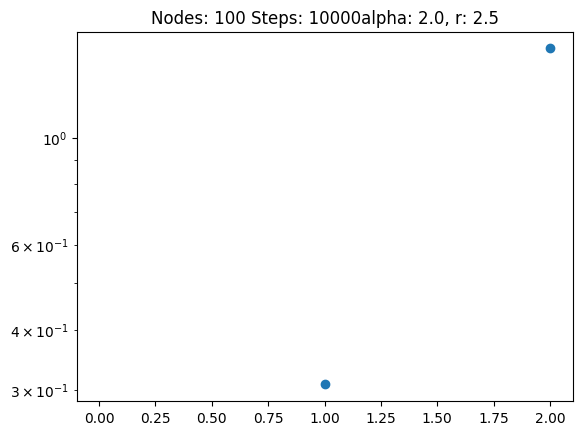

100 50000 2.0 0.5
9


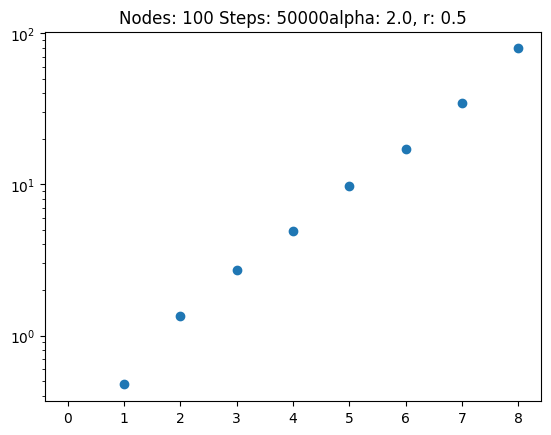

100 50000 2.0 0.2
13


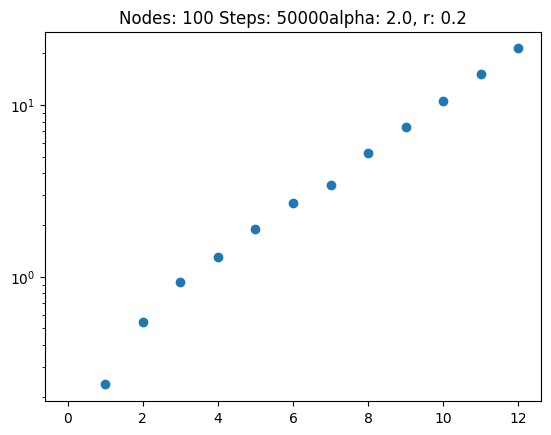

In [12]:
files = get_simulation_files()[1]
for prefix, file_list in files.items():
        num_nodes, num_steps, _, _ = process_prefix(prefix)
        if num_nodes == 100 and num_steps > 5000:
            for file in file_list:
                plot_first_passage(file)

In [13]:
def remove_max_and_avg(nums):
    no_nulls = nums[~np.isnan(nums)]
    return (np.sum(no_nulls) - np.max(no_nulls)) / np.size(no_nulls)

In [30]:
def plot_avg_size_of_small_component(prefix: str, file_list: List[str]) -> None:
    num_nodes, num_steps, alpha, r = process_prefix(prefix)
    print(num_nodes, num_steps, alpha, r)

    min_step: float = 1
    avg_small_sizes = np.zeros(num_steps)
    for file in file_list:
        with open(file) as f:
            next(f)
            lines = f.readlines()
            for step, line in enumerate(lines):
                sizes = np.fromstring(line, dtype=float, sep=" ")
                val = ((np.sum(sizes) - np.max(sizes)) / (np.size(sizes) - 1))
                avg_small_sizes[step] += val
    avg_small_sizes /= len(file_list)
    with open(file_list[0]) as f:
        min_step = float(f.readline().strip("\n"))



    x_values = np.arange(num_steps) * min_step / (float(num_nodes))
    skip_size: int = num_steps // 100
    plt.title("Nodes: " + str(num_nodes) + " Steps: " + str(num_steps) + "alpha: " + str(alpha) + ", r: " + str(r))
    plt.errorbar(x_values[::skip_size], avg_small_sizes[::skip_size], fmt="o")
    plt.show()

10000 20000 2.0 0.5


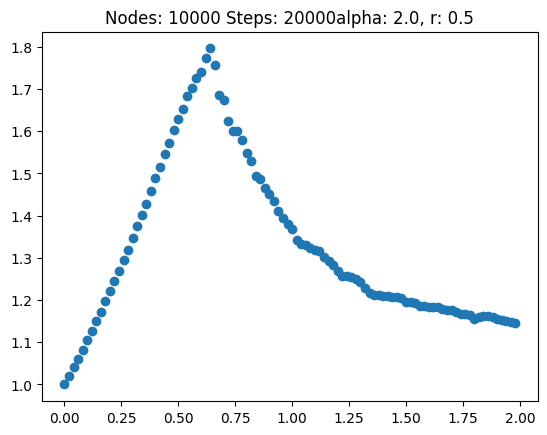

100 1000 2.0 0.5


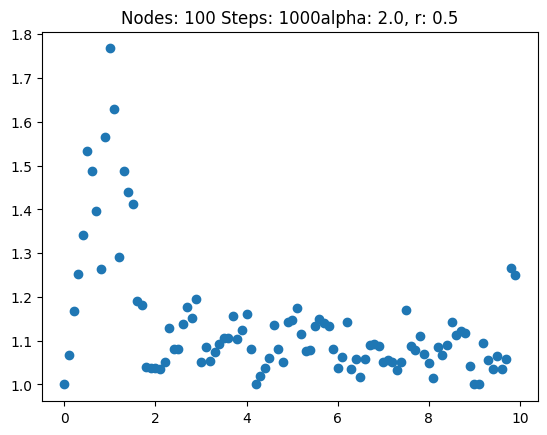

100 200 1.0 0.5


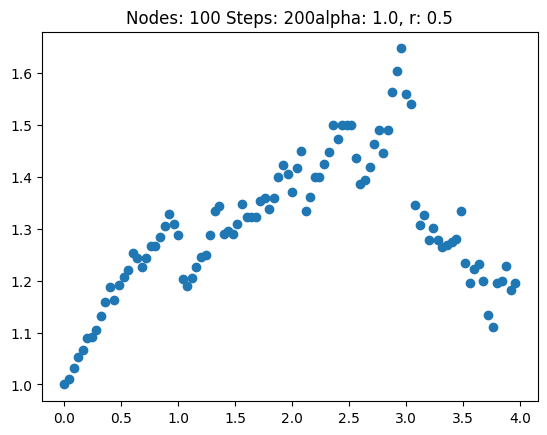

150 500 1.0 0.5


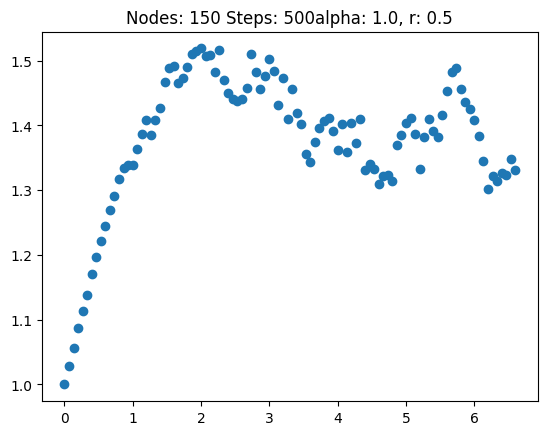

500 1500 2.0 0.25


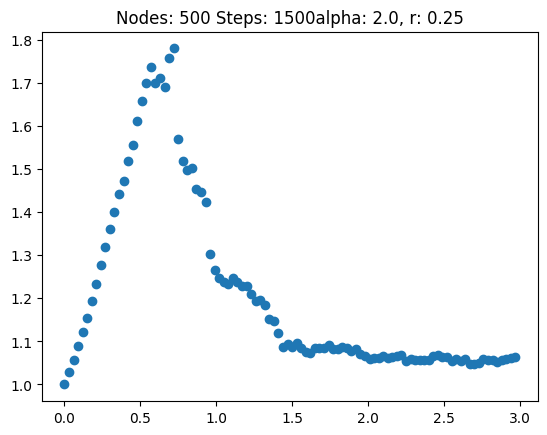

In [32]:
files = get_simulation_files()[3]
for prefix, file_list in files.items():
    plot_avg_size_of_small_component(prefix=prefix, file_list=file_list)


In [47]:
def plot_u(expected_k_t: float, pk_t: List[float], num_nodes) -> Tuple[List[float], List[float]]:
    u_values, f_u_values = [], []
    for u in range(1000):
        u = u / 1000
        u_values.append(u)
        sum_u = 0
        for k in range(1, num_nodes):
            sum_u += k * pk_t[k] * (u ** (k - 1))
        f_u_values.append(sum_u / expected_k_t)

    return u_values, f_u_values

def calculate_u(expected_k_t: float, pk_t: List[float], num_nodes) -> float:

    diff = 0.1  # It just needs to be better than the acceptance threshold
    u = 0.5  # Initial value
    sum_u = 0
    while abs(diff) > 1e-6:
        sum_u = 0
        sum_du = 0
        for k in range(1, num_nodes):
            sum_u += k * pk_t[k] * (u ** (k - 1))
            sum_du += k * (k - 1) * pk_t[k] * (u ** (k - 2))
        diff = u - sum_u / expected_k_t
        u = u - (u - sum_u / expected_k_t)/(1 - sum_du / expected_k_t)
    print(u, sum_u/expected_k_t, diff)
    return u

0.9999999999999976 0.999999996493727 -1.3454006797530838e-09


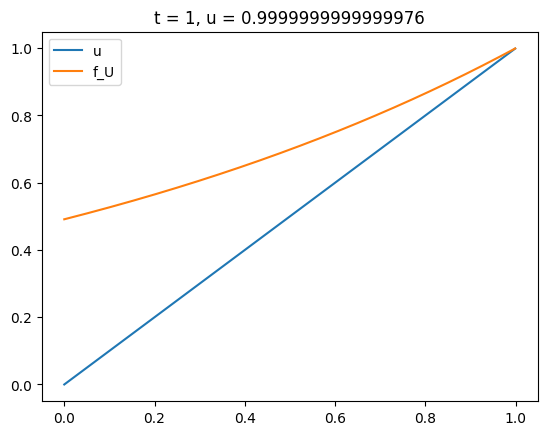

0.8815376611780218 0.8815335025627439 -2.9540039758746417e-07


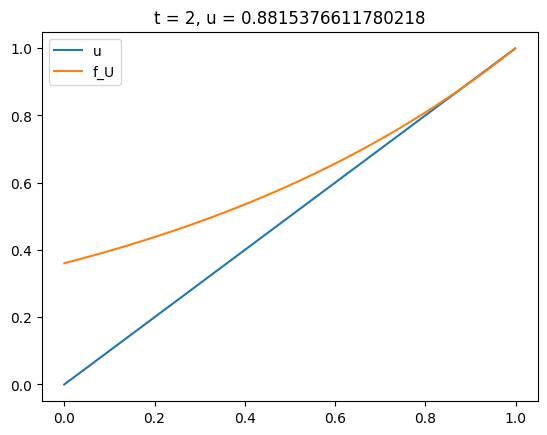

0.685476545797801 0.685476542627344 -7.637502852375633e-10


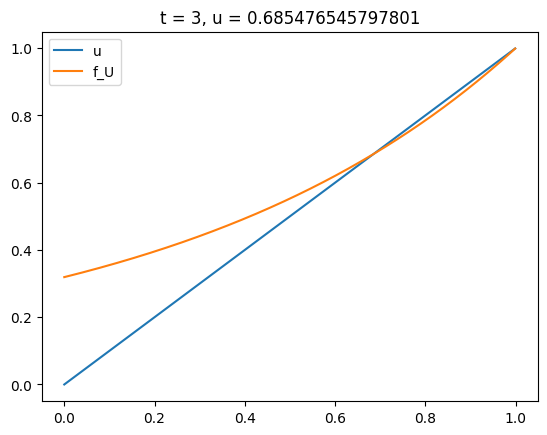

0.6245182010550628 0.6245171550669332 -3.3152263068103593e-07


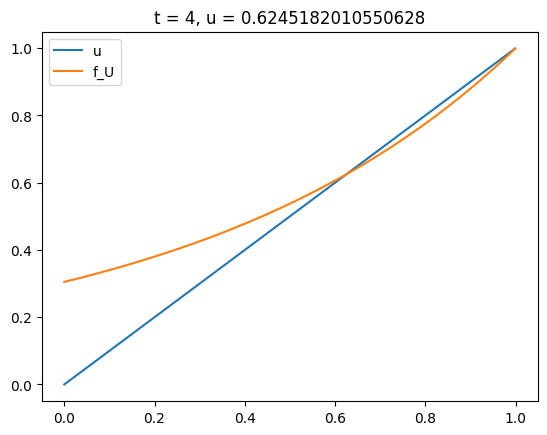

0.60308161419512 0.6030814036681671 -7.329839823988493e-08


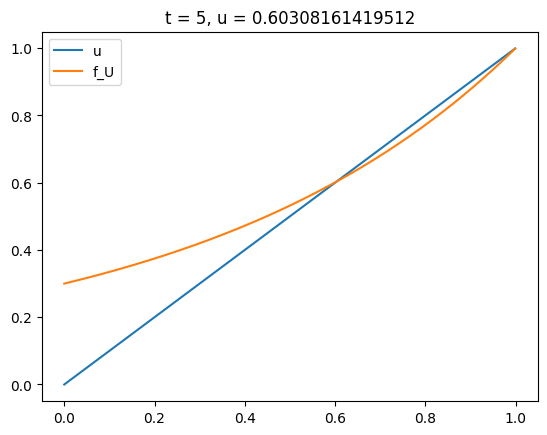

0.59523459174567 0.5952344841957167 -3.8760425424833045e-08


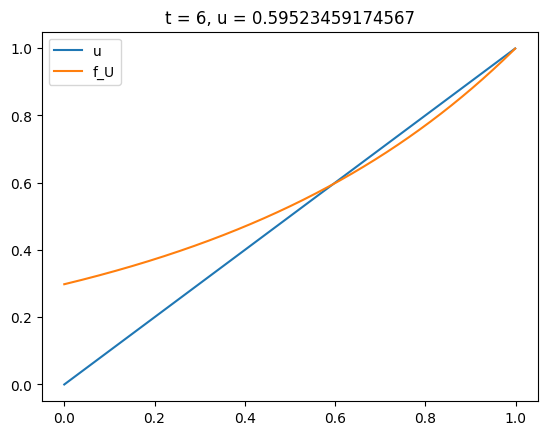

0.5923303505657399 0.5923302678735044 -3.018769290097367e-08


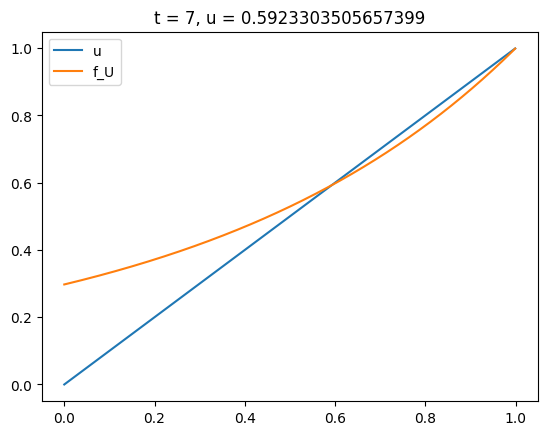

0.591254144559903 0.5912540697042938 -2.7458160523075037e-08


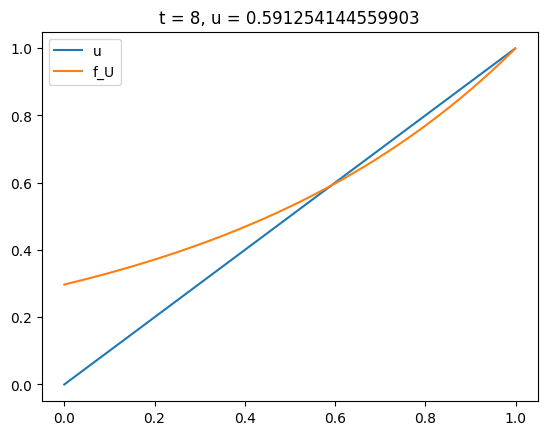

0.5908559210118839 0.5908558488869078 -2.6503676253675224e-08


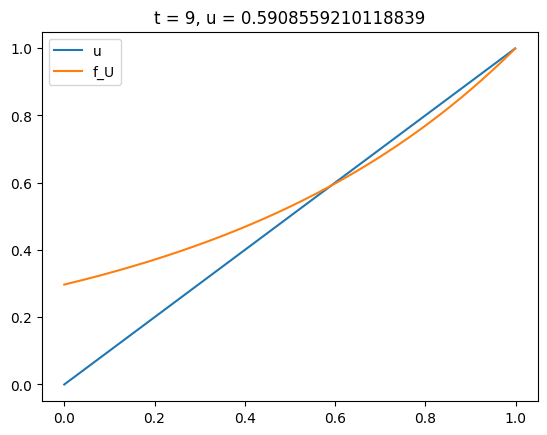

0.5907088258491063 0.5907087547107213 -2.6158378241269986e-08


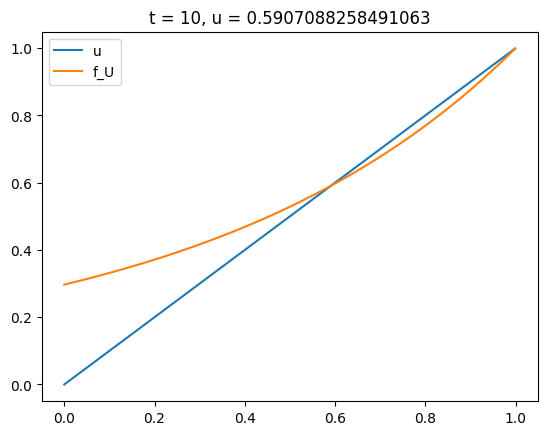

In [48]:
expected_k = expected_k_builder(alpha=1, r=0.5)
pk = pk_builder(alpha=1, r=0.5)

num_nodes = 1000
for t in range(1, 11):
    u, f_u = plot_u(expected_k_t=expected_k(t), pk_t=[pk(k, t) for k in range(num_nodes)], num_nodes=num_nodes)
    plt.title("t = " + str(t) +  ", u = " + str(calculate_u(expected_k_t=expected_k(t), pk_t=[pk(k, t) for k in range(num_nodes)], num_nodes=num_nodes)))
    plt.plot(u, u, label = "u")
    plt.plot(u, f_u, label = "f_U")
    plt.legend()
    plt.show()